In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import struct
import numpy as np
import os

def read_file(folder_name: str) -> dict:
    """
    此函数从文件夹下读取所有形如idxn-ubyte的数据文件.
    :param folder_name: 文件夹字符串名.
    :return: 包含所有以文件名（不含后缀名）为key，ndarray为value的字典.
    """
    # 检查输入的文件夹是否存在，是否可读
    if not os.path.exists(folder_name):
        raise FileNotFoundError(f"Folder doesn't exists: {folder_name}")
    if not os.access(folder_name, os.R_OK):
        raise PermissionError(f"Folder not readable: {folder_name}")

    return_dict = {}
    for elements in os.scandir(folder_name):
        if elements.is_file():
            with open(elements.path, 'rb') as file:
                magic, size = struct.unpack('>II', file.read(8))
                dimension = magic & 0xFF  # 使用位运算获取存储数据的维数
                lengths = (size,) + struct.unpack(f">{dimension - 1}I",
                                                  file.read((dimension - 1) * 4))  #定义期望得到的ndarray结构
                data_temp = np.fromfile(file, dtype=np.uint8).reshape(lengths)  # 读取二进制文件并重整成正确的结构
                return_dict[os.path.splitext(elements.name)[0]] = data_temp
    return return_dict


# 读取数据
files = read_file('./dataset')

In [3]:
import lyutorch as lyu
img_train = lyu.tensor(files['train-images'] * 2 / 255 - 1, dtype=np.float32)
img_test = lyu.tensor(files['t10k-images'] * 2 / 255 - 1, dtype=np.float32)
label_train = lyu.tensor(files['train-labels'], dtype=np.int8)
label_test = lyu.tensor(files['t10k-labels'], dtype=np.int8)

# 将数据变成 one-hot 编码
one_hot_matrix = np.eye(10)
label_train = lyu.tensor(one_hot_matrix[label_train.flatten()].reshape(-1,10).squeeze())
label_test = lyu.tensor(one_hot_matrix[label_test.flatten()].reshape(-1,10).squeeze())

print(label_train.shape)

(60000, 10)


In [4]:
import lyutorch.nn as nn


class Net(nn.Module):
    def __init__(self, hidden_layer_size: int = 64):
        super(Net, self).__init__()
        self._hidden = hidden_layer_size
        self.fc1 = lyu.tensor(np.random.normal(size=(28 * 28, hidden_layer_size)), requires_grad=True)
        self.fc2 = lyu.tensor(np.random.normal(size=(hidden_layer_size, 10)), requires_grad=True)
        self.bias1 = lyu.tensor(np.random.normal(size=(1, hidden_layer_size)), requires_grad=True)
        self.bias2 = lyu.tensor(np.random.normal(size=(1, 10)), requires_grad=True)
        self.add_parameter('fc1', self.fc1)
        self.add_parameter('fc2', self.fc2)
        self.add_parameter('bias1', self.bias1)
        self.add_parameter('bias2', self.bias2)
        self.target = lyu.tensor(np.eye(10))

    def forward(self, x):
        x = x @ self.fc1
        x = x + self.bias1
        x = nn.functional.relu(x)
        x = x @ self.fc2
        x = x + self.bias2
        x = nn.functional.softmax(x, self.target)
        return x

    def l2normalization(self):
        return (lyu.linalg.norm2(self.fc1, order=2) + lyu.linalg.norm2(self.fc2, order=2) + lyu.linalg.norm2(
            self.bias1, order=2) + lyu.linalg.norm2(self.bias2, order=2)) * lyu.tensor(
            1 / (28 * 28 * self._hidden + self._hidden * 10 + 10 + self._hidden))

    def grad_off(self):
        for key, value in self.parameters():
            value.requires_grad = False

    def grad_on(self):
        for key, value in self.parameters():
            value.requires_grad = True


img_train = img_train.reshape((60000, 28 * 28))
img_test = img_test.reshape((10000, 28 * 28))
# 创建网络实例
net = Net(hidden_layer_size=64)

In [5]:
net = Net(hidden_layer_size=16)
sgd = nn.Optimizer(net.parameters(), lr=0.01)
sgd.zero_grad()
losses32 = []
BATCH_SIZE = 32
data = nn.DataLoader([img_train, label_train], shuffle=True, batch_size=BATCH_SIZE)
batch = 0
size = len(img_train)
for epochs in range(3):
    for data_train in data:
        sgd.zero_grad()
        img = data_train[0]
        label = data_train[1]
        output = net(img)
        loss = nn.functional.cross_entropy_loss(output, label) + net.l2normalization()
        loss.backward()
        sgd.step()
        batch += 1
        losses32.append(loss.item())
        if batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{batch * BATCH_SIZE:>5d}/{size:>5d}]")

loss: 6.405772  [ 3200/60000]
loss: 2.630795  [ 6400/60000]
loss: 3.077320  [ 9600/60000]
loss: 1.976012  [12800/60000]
loss: 2.406154  [16000/60000]
loss: 2.043339  [19200/60000]
loss: 2.194631  [22400/60000]
loss: 2.164915  [25600/60000]
loss: 2.179823  [28800/60000]
loss: 1.932908  [32000/60000]
loss: 2.207437  [35200/60000]
loss: 2.231259  [38400/60000]
loss: 2.292315  [41600/60000]
loss: 1.791020  [44800/60000]
loss: 2.057045  [48000/60000]
loss: 2.203714  [51200/60000]
loss: 2.013211  [54400/60000]
loss: 2.237341  [57600/60000]
loss: 1.829764  [60800/60000]
loss: 1.926745  [64000/60000]
loss: 1.812204  [67200/60000]
loss: 1.805842  [70400/60000]
loss: 1.734487  [73600/60000]
loss: 2.053882  [76800/60000]
loss: 1.817120  [80000/60000]
loss: 1.770933  [83200/60000]
loss: 1.561904  [86400/60000]
loss: 1.951966  [89600/60000]
loss: 1.690912  [92800/60000]
loss: 1.443573  [96000/60000]
loss: 1.751086  [99200/60000]
loss: 1.436838  [102400/60000]
loss: 1.890158  [105600/60000]
loss: 1.

Text(0, 0.5, 'Loss')

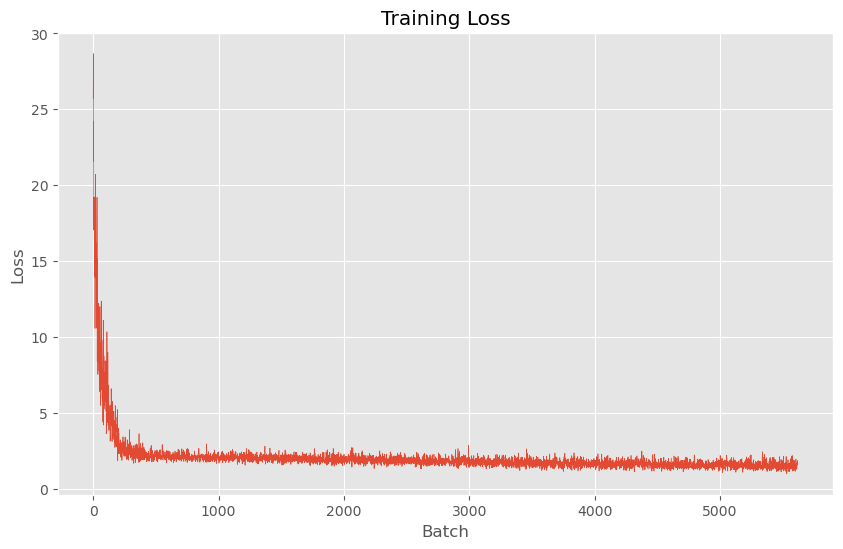

In [6]:
import matplotlib.pyplot as plt

# 设置样式为 'ggplot'
plt.style.use('ggplot')

# 创建一个新的图像，并设置其大小
plt.figure(figsize=(10, 6))

# 绘制损失值，设置线的宽度为 1
plt.plot(losses32[5:], linewidth=0.5)

# 设置图像的标题和坐标轴标签
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')

In [7]:
import numpy as np
np.save('losses16.npy', losses32)

In [8]:
net = Net(hidden_layer_size=16)
sgd = nn.Optimizer(net.parameters(), lr=0.001)
sgd.zero_grad()
losses32 = []
BATCH_SIZE = 32
data = nn.DataLoader([img_train, label_train], shuffle=True, batch_size=BATCH_SIZE)
batch = 0
size = len(img_train)
for epochs in range(3):
    for data_train in data:
        sgd.zero_grad()
        img = data_train[0]
        label = data_train[1]
        output = net(img)
        loss = nn.functional.cross_entropy_loss(output, label) + net.l2normalization()
        loss.backward()
        sgd.step()
        batch += 1
        losses32.append(loss.item())
        if batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{batch * BATCH_SIZE:>5d}/{size:>5d}]")


loss: 25.394917  [ 3200/60000]
loss: 19.806436  [ 6400/60000]
loss: 19.239892  [ 9600/60000]
loss: 12.869013  [12800/60000]
loss: 11.972123  [16000/60000]
loss: 12.312352  [19200/60000]
loss: 9.941101  [22400/60000]
loss: 10.019858  [25600/60000]
loss: 12.968446  [28800/60000]
loss: 7.833062  [32000/60000]
loss: 9.241407  [35200/60000]
loss: 7.656447  [38400/60000]
loss: 6.895662  [41600/60000]
loss: 9.117019  [44800/60000]
loss: 6.411404  [48000/60000]
loss: 5.932874  [51200/60000]
loss: 5.726713  [54400/60000]
loss: 3.600673  [57600/60000]
loss: 4.182485  [60800/60000]
loss: 5.425649  [64000/60000]
loss: 4.674970  [67200/60000]
loss: 3.574562  [70400/60000]
loss: 3.982446  [73600/60000]
loss: 4.246972  [76800/60000]
loss: 5.072057  [80000/60000]
loss: 2.484225  [83200/60000]
loss: 4.641489  [86400/60000]
loss: 3.112912  [89600/60000]
loss: 2.793296  [92800/60000]
loss: 2.947848  [96000/60000]
loss: 2.632940  [99200/60000]
loss: 3.517249  [102400/60000]
loss: 2.686054  [105600/60000]


In [9]:
np.save('losses16-1e-3lr.npy', losses32)